<a href="https://colab.research.google.com/github/Anjasfedo/Learning-TensorFlow/blob/main/eat_tensorflow2_in_30_days/Chapter3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-2 Mid-level API: Demonstration

The example below use mid-level APIs in TensorFlow to implement a linear regression and a DNN binary classification model.

Mid-level API includes model layers, loss functions, optimizers, data pipelines, feature columns, etc.

In [34]:
import tensorflow as tf

# Time stamp
@tf.function
def printbar():
  today_ds = tf.timestamp()%(24*60*60)

  hour = tf.cast(today_ds//3600+8, tf.int32)%tf.constant(24)
  minute = tf.cast((today_ds%3600)//60, tf.int32)
  second = tf.cast(today_ds%60, tf.int32)

  def timeformat(m):
    if tf.strings.length(tf.strings.format('{}', m)) == 1:
      return tf.strings.format('0{}', m)
    else:
      return tf.strings.format('{}', m)

  timestrings =  tf.strings.join([timeformat(hour), timeformat(minute), timeformat(second)], separator=':')

  tf.print('==========' * 8 + timestrings)

## 1. Linear Regression Model

### (a) Data Preparation

In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers

In [25]:
# Number of samples
n = 400

In [26]:
# Generating the datasets
X = tf.random.uniform([n, 2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2.0)

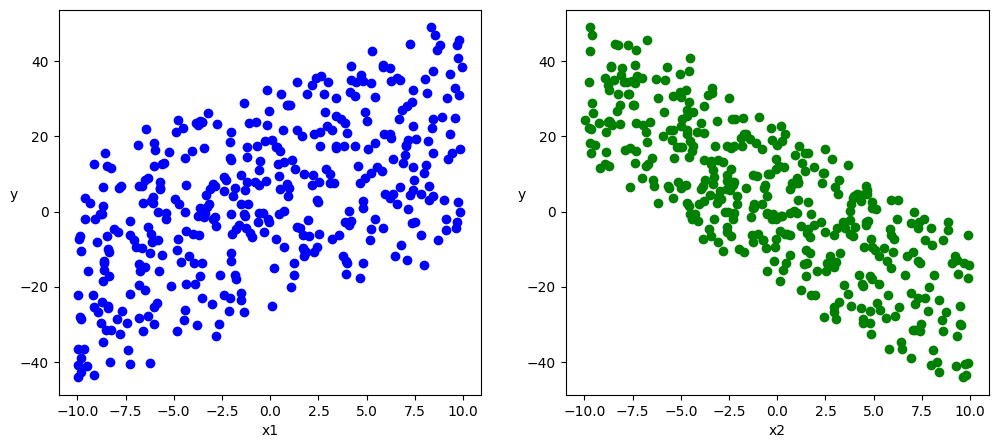

In [27]:
# Data visualization
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c='b')
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c = "g")
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()

In [42]:
# Create generator of data pipeline
ds = tf.data.Dataset.from_tensor_slices((X, Y)) \
  .shuffle(buffer_size=100).batch(32) \
  .prefetch(tf.data.experimental.AUTOTUNE)

### (b) Model Definition

In [43]:
model = layers.Dense(units=1)
model.build(input_shape=(2, )) # Create variables with build method
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

### (c) Model Training

In [44]:
# Accelerate using Autograph to transform the dynamic graph into static
@tf.function
def train_step(model, featurs, labels):
  with tf.GradientTape() as tape:
    predictions = model(featurs)
    loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))

  grads = tape.gradient(loss, model.variables)
  model.optimizer.apply_gradients(zip(grads, model.variables))

  return loss

# Test the results of train_step
features, labels = next(ds.as_numpy_iterator())
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=379.9667>

In [45]:
def train_model(model, epochs):
  for epoch in tf.range(1, epochs+1):
    loss = tf.constant(0.0)
    for features, labels in ds:
      loss = train_step(model, features, labels)

    if epoch % 50 == 0:
      printbar()
      tf.print("epoch =",epoch,"loss = ",loss)
      tf.print('w', model.variables[0])
      tf.print('b', model.variables[1])

train_model(model, epochs=200)

================================================================================11:51:27
epoch = 50 loss =  4.38681316
w [[2.01619577]
 [-3.01335788]]
b [2.25167322]
================================================================================11:51:31
epoch = 100 loss =  6.09418106
w [[2.02379489]
 [-3.00545788]]
b [2.87100792]
================================================================================11:51:34
epoch = 150 loss =  2.42260551
w [[2.0133791]
 [-2.99962187]]
b [3.03903913]
================================================================================11:51:35
epoch = 200 loss =  2.12098408
w [[2.01318645]
 [-3.00198483]]
b [3.08939791]


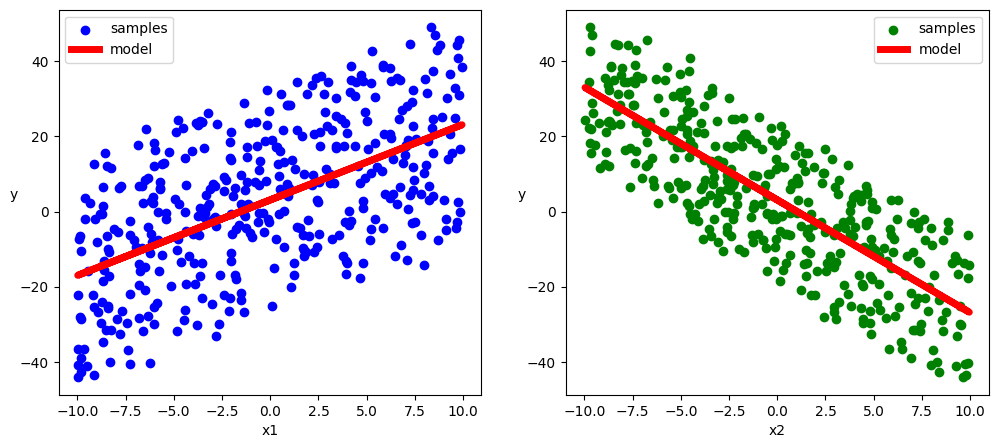

In [48]:
# Visualize the results

w, b = model.variables

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c='b', label='samples')
ax1.plot(X[:, 0], w[0] * X[:, 0] + b[0], "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c = "g", label='samples')
ax2.plot(X[:, 1], w[1] * X[:, 1] + b[0], "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()